# **Product Recommendation**

Ampika Thanakaew ID: 6210422049

## **Initialize**

In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from scipy.spatial.distance import cosine
from sklearn.decomposition import NMF

%cd '/content/drive/MyDrive/BADS 7105 CRM/Product Recommendation/'
%ls

/content/drive/MyDrive/BADS 7105 CRM/Product Recommendation
'Customer Preference Survey.csv'


In [85]:
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('/content/drive/MyDrive/BADS 7105 CRM/font/Cordia New Bold.ttf')
mpl.rc('font', family='Cordia New', size=12, weight=200)

**Load Data**

In [93]:
df = pd.read_csv("Customer Preference Survey.csv")
df.head(5)

,ประทับเวลา,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด,Unnamed: 62
0,2564/03/20 11:29:58 ก่อนเที่ยง GMT+7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,พริกทอด
1,2564/03/20 11:33:10 ก่อนเที่ยง GMT+7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,กล้วยทอด,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2564/03/20 11:53:44 ก่อนเที่ยง GMT+7,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,NaN
3,2564/03/20 11:54:00 ก่อนเที่ยง GMT+7,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,NaN
4,2564/03/20 11:54:05 ก่อนเที่ยง GMT+7,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,NaN


**Data Cleansing**

In [94]:
df.drop(columns={'Unnamed: 62', 'ประทับเวลา'}, axis=1, inplace=True)
df = df[2:]
df.head()

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
2,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย
3,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย
4,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย
5,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,เคย,ไม่เคย,เคย,เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย
6,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,NaN,ไม่เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,ไม่เคย,เคย,ไม่เคย,เคย,เคย,เคย


In [95]:
df.melt()['value'].value_counts(dropna=False)

ไม่เคย    1710
เคย       1090
NaN          6
Name: value, dtype: int64

**Data Processing**

In [96]:
df.fillna('ไม่เคย', inplace=True)
df.replace({'เคย': 1, 'ไม่เคย': 0}, inplace=True)
df.head(5)

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิล,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,เครื่องย่อยเศษอาหาร.1,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,1,1,1,0,0,0,0,1,0,1,1,0,1,0,0,1,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1
3,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,0,1,1,1,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,1,0,1,0,1,0,0,0,1,1,0,1,0,1
4,1,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,1,1,1,0,1,1,0,1,1,1,0,1,0,1,1,1,1,1,1,0,1,0,1,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,1,1,1
5,0,0,0,1,0,1,0,0,0,0,1,1,1,1,0,1,1,1,1,1,0,0,1,1,1,0,0,0,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
6,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,1,1


In [97]:
df[['เครื่องย่อยเศษอาหาร', 'เครื่องย่อยเศษอาหาร.1']].corr()

,เครื่องย่อยเศษอาหาร,เครื่องย่อยเศษอาหาร.1
เครื่องย่อยเศษอาหาร,1.0,1.0
เครื่องย่อยเศษอาหาร.1,1.0,1.0


In [98]:
df.drop('เครื่องย่อยเศษอาหาร.1', axis=1, inplace=True)

In [99]:
df.rename({'เนื้อวากิล':'เนื้อวากิว'}, axis=1, inplace=True)

**EDA**

In [100]:
df.describe().T.sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
ครีมกันแดด,46.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
กระเป๋า,46.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
ชาบู,46.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
โรตี,46.0,0.956522,0.206185,0.0,1.0,1.0,1.00,1.0
กะหรี่(ปั๊บ),46.0,0.934783,0.249637,0.0,1.0,1.0,1.00,1.0
เม็ดมะม่วงหิมพานต์,46.0,0.913043,0.284885,0.0,1.0,1.0,1.00,1.0
หมอนข้าง,46.0,0.869565,0.340503,0.0,1.0,1.0,1.00,1.0
หมูแดดเดียว,46.0,0.804348,0.401085,0.0,1.0,1.0,1.00,1.0
แฟน ที่แปลว่าพัดลม,46.0,0.804348,0.401085,0.0,1.0,1.0,1.00,1.0
Software ถูกลิขสิทธิ์,46.0,0.782609,0.417029,0.0,1.0,1.0,1.00,1.0


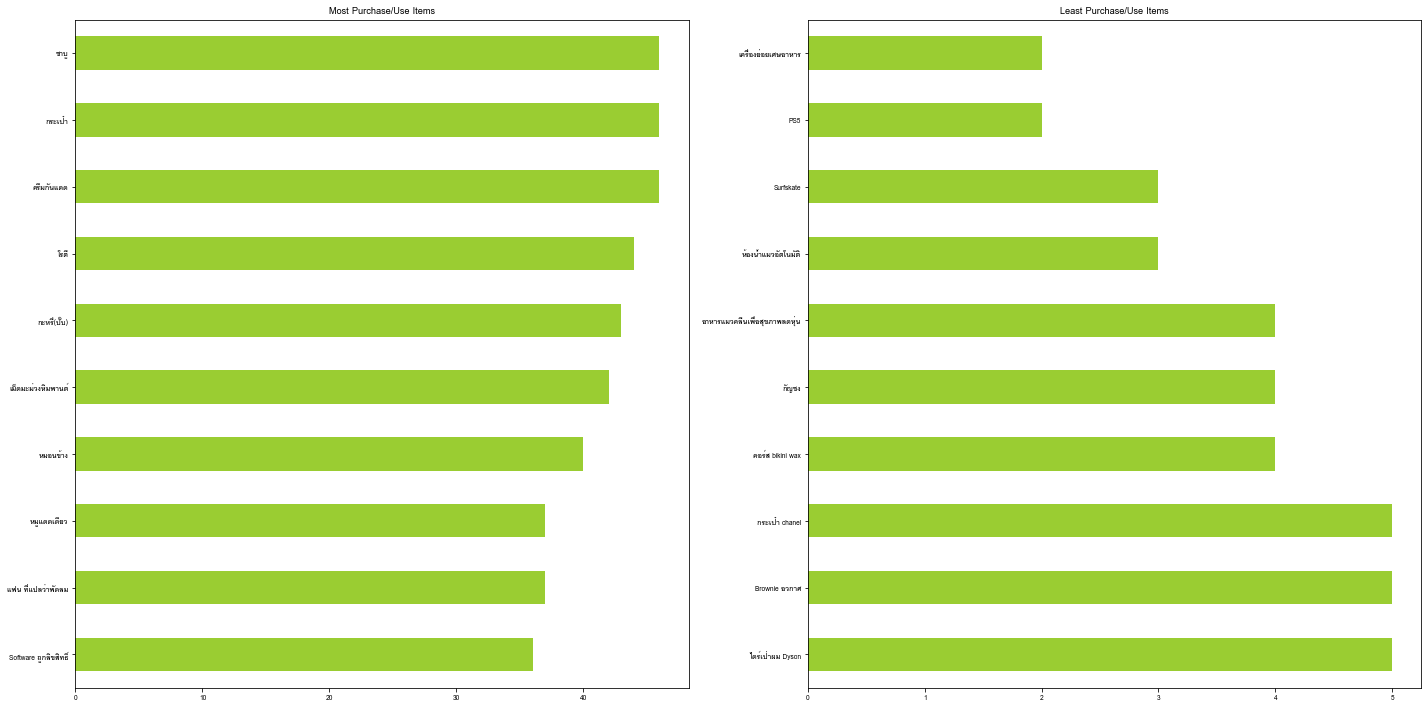

In [101]:
total_purchase_per_item = (
    df.sum().sort_values(ascending=False).to_frame().rename({0: 'count'}, axis=1)
)
most_purchase_items = total_purchase_per_item[:10]
least_purchase_items = total_purchase_per_item[-10:]

fig, axes = plt.subplots(1, 2, figsize=(20, 10), tight_layout=True)
most_purchase_items.sort_values('count', ascending=True).plot.barh(ax=axes[0], title='Most Purchase/Use Items', legend=False, color='yellowgreen')
least_purchase_items.plot.barh(ax=axes[1], title='Least Purchase/Use Items', legend=False, color='yellowgreen')
plt.rc('axes', titlesize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.show()

## **Frequent Itemsets & Association Rules**

In [102]:
frequent_itemsets = apriori(df, min_support=0.5, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_len"] = rules["consequents"].apply(lambda x: len(x))
rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequents_len
106796,"(เม็ดมะม่วงหิมพานต์, เนื้อย่าง, ตาชั่ง )","(กะหรี่(ปั๊บ), โรตี, แฟน ที่แปลว่าพัดลม)",0.5,0.76087,0.5,1.0,1.314286,0.119565,inf,3,3
210809,"(กระเป๋า, เม็ดมะม่วงหิมพานต์, เนื้อย่าง, ตาชั่ง )","(กะหรี่(ปั๊บ), โรตี, แฟน ที่แปลว่าพัดลม)",0.5,0.76087,0.5,1.0,1.314286,0.119565,inf,4,3
210838,"(เม็ดมะม่วงหิมพานต์, เนื้อย่าง, ตาชั่ง )","(กระเป๋า, กะหรี่(ปั๊บ), โรตี, แฟน ที่แปลว่าพัดลม)",0.5,0.76087,0.5,1.0,1.314286,0.119565,inf,3,4
211183,"(ชาบู, เม็ดมะม่วงหิมพานต์, เนื้อย่าง, ตาชั่ง )","(กะหรี่(ปั๊บ), โรตี, แฟน ที่แปลว่าพัดลม)",0.5,0.76087,0.5,1.0,1.314286,0.119565,inf,4,3
211223,"(เม็ดมะม่วงหิมพานต์, เนื้อย่าง, ตาชั่ง )","(ชาบู, โรตี, กะหรี่(ปั๊บ), แฟน ที่แปลว่าพัดลม)",0.5,0.76087,0.5,1.0,1.314286,0.119565,inf,3,4
211565,"(ครีมกันแดด, เม็ดมะม่วงหิมพานต์, เนื้อย่าง, ตา...","(กะหรี่(ปั๊บ), โรตี, แฟน ที่แปลว่าพัดลม)",0.5,0.76087,0.5,1.0,1.314286,0.119565,inf,4,3
211594,"(เม็ดมะม่วงหิมพานต์, เนื้อย่าง, ตาชั่ง )","(ครีมกันแดด, กะหรี่(ปั๊บ), โรตี, แฟน ที่แปลว่า...",0.5,0.76087,0.5,1.0,1.314286,0.119565,inf,3,4
310852,"(ชาบู, เม็ดมะม่วงหิมพานต์, ตาชั่ง , กระเป๋า, เ...","(กะหรี่(ปั๊บ), โรตี, แฟน ที่แปลว่าพัดลม)",0.5,0.76087,0.5,1.0,1.314286,0.119565,inf,5,3
310907,"(ชาบู, เม็ดมะม่วงหิมพานต์, เนื้อย่าง, ตาชั่ง )","(กระเป๋า, กะหรี่(ปั๊บ), โรตี, แฟน ที่แปลว่าพัดลม)",0.5,0.76087,0.5,1.0,1.314286,0.119565,inf,4,4
310928,"(กระเป๋า, เม็ดมะม่วงหิมพานต์, เนื้อย่าง, ตาชั่ง )","(ชาบู, โรตี, กะหรี่(ปั๊บ), แฟน ที่แปลว่าพัดลม)",0.5,0.76087,0.5,1.0,1.314286,0.119565,inf,4,4


**Recommend 1 item based on 1 item**

In [103]:
one_item_rule = rules[ 
    (rules['antecedent_len'] == 1) &
    (rules['consequents_len'] == 1) &
    (rules['confidence'] > 0.8) &
    (rules['lift'] > 1.00) 
]
one_item_rule["antecedents"] = one_item_rule["antecedents"].apply(lambda x: list(x)[0]).astype("unicode")
one_item_rule["consequents"] = one_item_rule["consequents"].apply(lambda x: list(x)[0]).astype("unicode")
one_item_rule = one_item_rule.sort_values('lift', ascending=False)
one_item_rule

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequents_len
160,เนื้อวากิว,เนื้อย่าง,0.673913,0.717391,0.652174,0.967742,1.348974,0.168715,8.760870,1,1
161,เนื้อย่าง,เนื้อวากิว,0.717391,0.673913,0.652174,0.909091,1.348974,0.168715,3.586957,1,1
18,Lego,ต้นไม้ประดับห้อง,0.630435,0.717391,0.543478,0.862069,1.201672,0.091210,2.048913,1,1
100,Lego,เนื้อย่าง,0.630435,0.717391,0.521739,0.827586,1.153605,0.069471,1.639130,1,1
158,เนื้อวากิว,หมูแดดเดียว,0.673913,0.804348,0.608696,0.903226,1.122929,0.066635,2.021739,1,1
...,...,...,...,...,...,...,...,...,...,...,...
152,เครื่องดูดฝุ่นอัตโนมัติ (robot),เม็ดมะม่วงหิมพานต์,0.543478,0.913043,0.500000,0.920000,1.007619,0.003781,1.086957,1,1
16,ต้นไม้ประดับห้อง,กะหรี่(ปั๊บ),0.717391,0.934783,0.673913,0.939394,1.004933,0.003308,1.076087,1,1
154,เครื่องดูดฝุ่นอัตโนมัติ (robot),โรตี,0.543478,0.956522,0.521739,0.960000,1.003636,0.001890,1.086957,1,1
184,Software ถูกลิขสิทธิ์,หมูแดดเดียว,0.782609,0.804348,0.630435,0.805556,1.001502,0.000945,1.006211,1,1


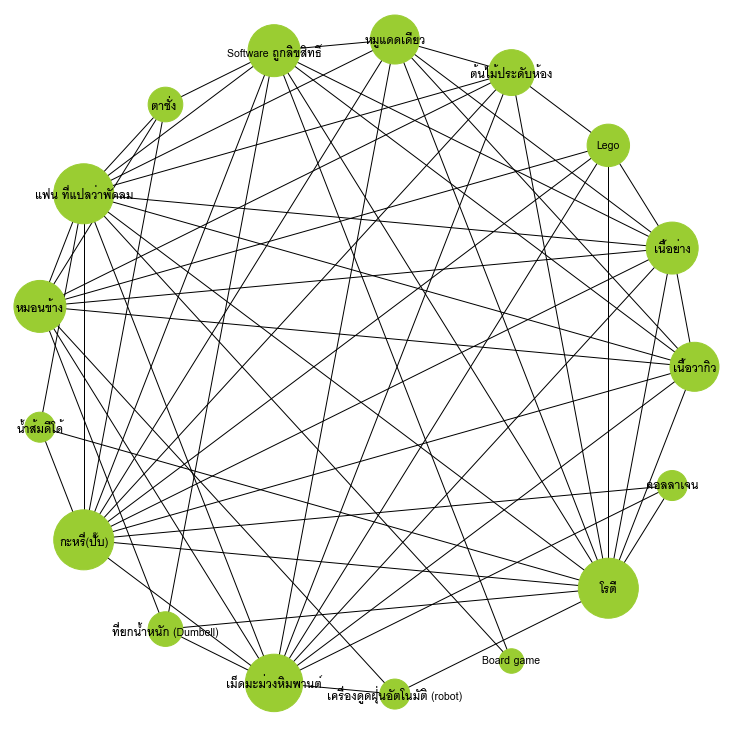

In [104]:
G = nx.from_pandas_edgelist(one_item_rule, source='antecedents', target='consequents', edge_attr='lift')
d = dict(G.degree)
nx.draw_circular(
    G, 
    node_size=[d[k] * 300 for k in dict(G.degree)], 
    with_labels=True, 
    font_family='Cordia New', 
    font_size='16',
    node_color='yellowgreen'
) 
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

**Recommend 2 items based on 1 item**

In [107]:
two_items_rule = rules[ 
    (rules['antecedent_len'] == 1) &
    (rules['consequents_len'] == 2) &
    (rules['confidence'] > 0.8) &
    (rules['lift'] > 1.20) 
]
two_items_rule["antecedents"] = two_items_rule["antecedents"].apply(lambda x: list(x)).astype("unicode")
two_items_rule["consequents"] = two_items_rule["consequents"].apply(lambda x: list(x)).astype("unicode")
two_items_rule = two_items_rule.sort_values('lift', ascending=False)
two_items_rule

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len,consequents_len
2305,['เนื้อวากิว'],"['หมูแดดเดียว', 'เนื้อย่าง']",0.673913,0.630435,0.586957,0.870968,1.381535,0.162098,2.864130,1,2
2371,['เนื้อวากิว'],"['Software ถูกลิขสิทธิ์', 'เนื้อย่าง']",0.673913,0.608696,0.565217,0.838710,1.377880,0.155009,2.426087,1,2
2355,['เนื้อย่าง'],"['เนื้อวากิว', 'ชาบู']",0.717391,0.673913,0.652174,0.909091,1.348974,0.168715,3.586957,1,2
2353,['เนื้อวากิว'],"['ชาบู', 'เนื้อย่าง']",0.673913,0.717391,0.652174,0.967742,1.348974,0.168715,8.760870,1,2
2379,['เนื้อย่าง'],"['เนื้อวากิว', 'ครีมกันแดด']",0.717391,0.673913,0.652174,0.909091,1.348974,0.168715,3.586957,1,2
2367,['เนื้อย่าง'],"['เนื้อวากิว', 'โรตี']",0.717391,0.673913,0.652174,0.909091,1.348974,0.168715,3.586957,1,2
2347,['เนื้อวากิว'],"['กระเป๋า', 'เนื้อย่าง']",0.673913,0.717391,0.652174,0.967742,1.348974,0.168715,8.760870,1,2
2349,['เนื้อย่าง'],"['เนื้อวากิว', 'กระเป๋า']",0.717391,0.673913,0.652174,0.909091,1.348974,0.168715,3.586957,1,2
2365,['เนื้อวากิว'],"['โรตี', 'เนื้อย่าง']",0.673913,0.717391,0.652174,0.967742,1.348974,0.168715,8.760870,1,2
2377,['เนื้อวากิว'],"['ครีมกันแดด', 'เนื้อย่าง']",0.673913,0.717391,0.652174,0.967742,1.348974,0.168715,8.760870,1,2


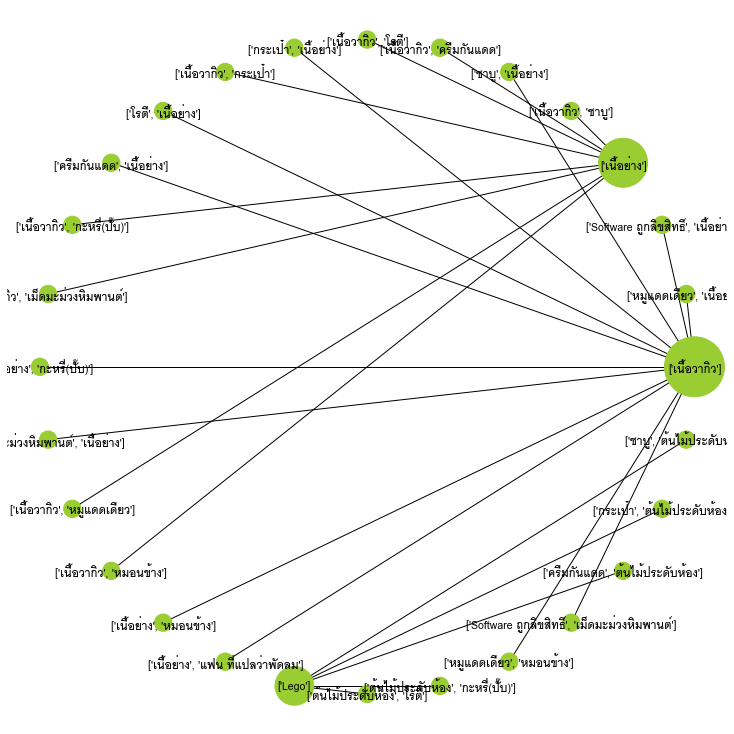

In [108]:
G = nx.from_pandas_edgelist(two_items_rule, source='antecedents', target='consequents')
d = dict(G.degree)
nx.draw_circular(
    G, 
    node_size=[d[k] * 300 for k in dict(G.degree)], 
    with_labels=True, 
    font_family='Cordia New', 
    font_size='16',
    node_color='yellowgreen'
) 
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

## **Collaborative Filtering Model**

In [128]:
item_item_df = pd.DataFrame(index=df.columns,columns=df.columns)

for i in range(0,len(item_item_df.columns)) :
    for j in range(0,len(item_item_df.columns)) :
      item_item_df.iloc[i, j] = 1 - cosine(df.iloc[: , i], df.iloc[: , j])
item_item_df.head(5)

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิว,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
จักรยานเสือภูเขา,1,0.55,0.33541,0.400892,0.416667,0.265165,0.25,0.458831,0.452267,0.125,0.102062,0.522233,0.592927,0.583717,0.223607,0.375,0.533745,0.60351,0.534297,0.216506,0.188982,0.661438,0.55,0.538816,0.452097,0.306186,0.353553,0.376889,0.301511,0.565752,0.472456,0.589768,0.589768,0.433013,0.417815,0.375,0.395285,0.540062,0.580948,0.265165,0.33541,0.416667,0.53033,0.176777,0.474342,0.603023,0.416667,0.395285,0.381881,0.102062,0.471405,0.433013,0.33541,0.306186,0.0883883,0.471405,0.375,0.456435,0.583333,0.589768
คอลลาเจน,0.55,1,0.268328,0.320713,0.533333,0.141421,0.2,0.458831,0.361814,0.4,0.163299,0.661495,0.664078,0.610658,0.447214,0.3,0.731993,0.705642,0.624716,0.404145,0.377964,0.680336,0.6,0.538816,0.624716,0.326599,0.282843,0.603023,0.482418,0.591864,0.377964,0.73721,0.73721,0.23094,0.482808,0.6,0.316228,0.709795,0.464758,0.353553,0.357771,0.333333,0.518545,0.141421,0.442719,0.753778,0.466667,0.505964,0.523723,0.244949,0.565685,0.34641,0.357771,0.244949,0.282843,0.612826,0.4,0.657267,0.7,0.73721
Brownie อวกาศ,0.33541,0.268328,1,0.478091,0.447214,0.632456,0.67082,0.102598,0.13484,0.223607,0.365148,0.389249,0.282843,0.321288,0.2,0.33541,0.340997,0.415227,0.367607,0.258199,0.169031,0.338062,0.357771,0.40161,0.294086,0.365148,0.316228,0.13484,0.26968,0.3114,0.169031,0.32969,0.32969,0.258199,0.249136,0.111803,0.424264,0.345033,0.34641,0.316228,0.2,0.596285,0.210819,0.316228,0.282843,0.3371,0.298142,0.141421,0.29277,0.365148,0.210819,0.516398,0.8,0.547723,0.158114,0.316228,0.447214,0.244949,0.372678,0.32969
แม่โขง,0.400892,0.320713,0.478091,1,0.267261,0.566947,0.400892,0.367884,0.241747,0.133631,0.436436,0.558291,0.507093,0.432014,0.119523,0.868599,0.570597,0.397033,0.52725,0.308607,0.303046,0.454569,0.427618,0.576018,0.571187,0.327327,0.188982,0.241747,0.402911,0.511766,0.202031,0.551677,0.551677,0.154303,0.397033,0.0668153,0.507093,0.57735,0.276026,0.283473,0.239046,0.445435,0.566947,0.188982,0.169031,0.564076,0.356348,0,0.349927,0.327327,0.377964,0.46291,0.358569,0.218218,0.188982,0.440959,0.267261,0.39036,0.400892,0.551677
Botox,0.416667,0.533333,0.447214,0.267261,1,0.235702,0.333333,0.229416,0.301511,0.166667,0.136083,0.348155,0.368932,0.299342,0.745356,0.25,0.406663,0.309492,0.493197,0.288675,0.377964,0.503953,0.333333,0.359211,0.328798,0.136083,0.235702,0.402015,0.402015,0.348155,0.251976,0.442326,0.442326,0.19245,0.185695,0.333333,0.316228,0.411476,0.258199,0.235702,0.298142,0.333333,0.31427,0.235702,0.421637,0.452267,0.333333,0.316228,0.363696,0.136083,0.235702,0.19245,0.596285,0.408248,0.117851,0.392837,0.166667,0.30429,0.5,0.442326


In [134]:
item_item_matrix_df = (item_item_df.stack().reset_index().rename(columns={'level_0': 'item_1', 'level_1': 'item_2', 0: 'similarity'}))
item_item_matrix_df 

,item_1,item_2,similarity
0,จักรยานเสือภูเขา,จักรยานเสือภูเขา,1
1,จักรยานเสือภูเขา,คอลลาเจน,0.55
2,จักรยานเสือภูเขา,Brownie อวกาศ,0.33541
3,จักรยานเสือภูเขา,แม่โขง,0.400892
4,จักรยานเสือภูเขา,Botox,0.416667
...,...,...,...
3595,ครีมกันแดด,หมอนสุขภาพสำหรับคนนอนไม่หลับ,0.625543
3596,ครีมกันแดด,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,0.294884
3597,ครีมกันแดด,น้ำส้มดีโด้,0.807573
3598,ครีมกันแดด,Software ถูกลิขสิทธิ์,0.884652


In [145]:
item_item_matrix_df = item_item_matrix_df.loc[(item_item_matrix_df['similarity'] > 0.7) & (item_item_matrix_df['item_1'] != item_item_matrix_df['item_2'])]
item_item_matrix_df.sort_values('similarity', ascending=False)

,item_1,item_2,similarity
1979,ชาบู,ครีมกันแดด,1
3572,ครีมกันแดด,ชาบู,1
3571,ครีมกันแดด,กระเป๋า,1
1919,กระเป๋า,ครีมกันแดด,1
1892,กระเป๋า,ชาบู,1
...,...,...,...
1038,Lego,แฟน ที่แปลว่าพัดลม,0.702147
982,กะหรี่(ปั๊บ),เครื่องดูดฝุ่นอัตโนมัติ (robot),0.701493
1336,เครื่องดูดฝุ่นอัตโนมัติ (robot),กะหรี่(ปั๊บ),0.701493
518,หลอดไฟเปลี่ยนสีได้,ไฟอัจฉริยะ,0.700649


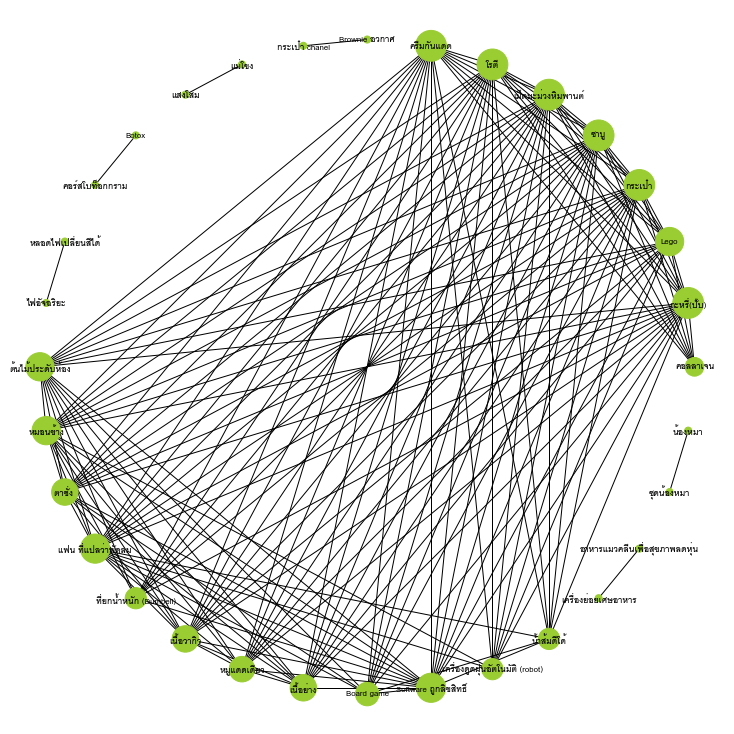

In [146]:
G = nx.from_pandas_edgelist(item_item_matrix_df, source='item_1', target='item_2', edge_attr='similarity')
d = dict(G.degree)
nx.draw_circular(
    G, 
    node_size=[d[k] * 50 for k in dict(G.degree)], 
    with_labels=True, 
    font_family='Cordia New', 
    font_size='12',
    node_color='yellowgreen'
) 
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()

## **Matrix Factorization**

**Non-Matrix Factorization**

In [147]:
nmf = NMF(n_components=10, random_state=48, max_iter=1000)
W = nmf.fit_transform(df)
H = nmf.components_
nR = np.dot(W,H)
nmf_df = pd.DataFrame(nR, columns=df.columns, index=df.index)
nmf_df.head()

,จักรยานเสือภูเขา,คอลลาเจน,Brownie อวกาศ,แม่โขง,Botox,กัญชา,กัญชง,เครื่องวัดความดัน,หลอดไฟเปลี่ยนสีได้,คอร์ส bikini wax,เก้าอี้นวดไฟฟ้า,ต้นไม้ประดับห้อง,หมอนข้าง,ตาชั่ง,คอร์สโบท็อกกราม,แสงโสม,กะหรี่(ปั๊บ),Lego,แฟน ที่แปลว่าพัดลม,ยาดอง,ชุดนอนไม่ได้นอน,ที่ยกน้ำหนัก (Dumbell),เครื่องดูดฝุ่นอัตโนมัติ (robot),เนื้อวากิว,หมูแดดเดียว,drone,เครื่องย่อยเศษอาหาร,เสื้อซีทรู,ไพ่ยิปซี,เนื้อย่าง,เครื่องทำลายเอกสาร,กระเป๋า,ชาบู,Surfskate,Board game,ชุดน้องหมา,Omakase,เม็ดมะม่วงหิมพานต์,ไฟอัจฉริยะ,บัตตาเลี่ยนที่ตัดผม,ไดร์เป่าผม Dyson,แผ่นเสียง,กรรไกรตัดขนจมูก,PS5,เครื่องตรวจน้ำตาลในเลือด,โรตี,กะปิดอง,น้องหมา,แพ็คเกจไทยเที่ยวไทย,เกมส์ FIFA Online,มะม่วงเบา,ห้องน้ำแมวอัตโนมัติ,กระเป๋า chanel,ข้าวขาหมูคากิคาจักออนไลน์,ถั่งเช่า,หมอนสุขภาพสำหรับคนนอนไม่หลับ,อาหารแมวคลีนเพื่อสุขภาพลดหุ่น,น้ำส้มดีโด้,Software ถูกลิขสิทธิ์,ครีมกันแดด
2,0.053670,0.152704,0.067116,0.222360,0.009537,0.308858,0.052266,0.100398,0.056970,0.064779,0.247083,0.522541,0.675079,0.501323,0.022976,0.255659,1.086565,0.518097,0.848098,0.339260,0.062863,0.155756,0.269110,0.962447,1.056637,0.155149,0.004658,0.112694,0.068419,1.023025,0.056478,0.975818,0.975818,0.033959,1.043351,0.053046,0.285270,0.879423,0.062106,0.256675,0.057912,0.148372,0.352643,0.037248,0.030318,1.008716,0.016326,0.056318,0.183633,0.303133,0.308896,0.000000,0.012284,0.044923,0.004647,0.203919,0.045507,0.907759,0.915165,0.975818
3,0.253541,0.585680,0.085894,0.973853,0.108063,0.000000,0.000000,0.676588,0.118020,0.449126,0.009440,0.704984,1.025825,0.717542,0.256759,1.136959,1.021548,0.232700,0.814444,0.000000,0.787183,0.787647,0.793987,0.346312,1.015187,0.078550,0.002406,0.877796,0.809791,0.347809,0.028113,1.048680,1.048680,0.021578,0.181649,0.124458,0.306663,1.185477,0.123553,0.026755,0.089668,0.034514,0.956442,0.006159,0.466571,0.842729,0.601520,0.334721,1.250071,0.086446,0.860869,0.151529,0.135847,0.242123,0.930069,1.121418,0.018005,0.804619,0.107459,1.048680
4,0.747454,0.831235,0.039436,0.000021,0.066368,0.022959,0.046813,0.914220,0.758005,0.373549,0.104852,0.896691,0.973884,1.063350,0.159881,0.000000,0.989177,0.965355,0.762811,0.058819,0.437452,0.755006,0.845774,1.022136,0.924722,0.214690,0.076617,0.639764,0.279857,1.107669,0.413184,1.022459,1.022459,0.239678,0.969351,0.786465,0.201245,0.896873,1.084741,0.231246,0.325638,0.082800,0.795936,0.025129,0.847495,1.112638,0.198412,0.654466,0.050310,0.198244,0.760554,0.000000,0.076560,0.165963,0.067462,0.769477,0.193489,1.029328,1.134454,1.022459
5,0.029270,0.018860,0.199223,0.844148,0.000000,0.932973,0.030039,0.081648,0.014020,0.082882,0.801657,1.284605,1.076732,0.619515,0.000000,0.972761,0.917190,1.383515,0.916540,1.088641,0.003178,0.090532,0.851856,0.970313,1.116085,0.423124,0.000258,0.002336,0.009772,1.003261,0.004621,0.932111,0.932111,0.111447,1.058991,0.000000,0.779820,1.003828,0.010695,0.625482,0.005932,0.122139,0.821773,0.002891,0.003585,0.970799,0.040779,0.000000,0.359367,0.962566,0.049393,0.019177,0.004156,0.000659,0.000198,0.035713,0.130917,0.103998,0.147208,0.932111
6,0.342657,1.038839,0.193281,0.136237,0.662614,0.125127,0.124003,0.092865,0.181047,0.155991,0.049245,0.510858,0.569256,0.445459,0.445479,0.117099,1.036756,0.611789,0.827291,0.529259,0.303173,0.789740,0.265749,0.200184,0.673336,0.104851,0.116703,0.495731,0.217671,0.241793,0.216243,1.033433,1.033433,0.079088,0.822112,0.691363,0.240793,0.764932,0.113229,0.146752,0.136766,0.357832,0.236438,0.109627,0.141590,1.006768,0.216447,0.458488,0.403442,0.025754,0.310981,0.108089,0.235689,0.097925,0.018404,0.586762,0.099648,1.141385,0.967936,1.033433


**Recommend items to users**

In [148]:
def get_recommend_items(row):
    recommend_df = row.sort_values(ascending=False).head(3).to_frame().reset_index()
    recommend_df.columns = ['item', 'value']
    recommend_items = recommend_df['item']
    recommend_value = recommend_df['value']
    return (", ".join([item + " " + str(value) for item, value in zip(recommend_items.values, recommend_value.values)]))

nmf_df['recommend'] = nmf_df.apply(lambda row: get_recommend_items(row), axis=1)

In [149]:
(
    nmf_df
    .reset_index()
    .rename(columns={'index': 'user'})
)[['user', 'recommend']].head()

,user,recommend
0,2,"กะหรี่(ปั๊บ) 1.0865652752541328, หมูแดดเดียว 1..."
1,3,"แพ็คเกจไทยเที่ยวไทย 1.250070744652351, เม็ดมะม..."
2,4,"Software ถูกลิขสิทธิ์ 1.1344540321176917, โรตี..."
3,5,"Lego 1.383515040567785, ต้นไม้ประดับห้อง 1.284..."
4,6,"น้ำส้มดีโด้ 1.1413850669807521, คอลลาเจน 1.038..."
